In [1]:
# Import finance API and get historical stock data

import yfinance as yf
import os
import json
import pandas as pd

DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    msft_hist.to_json(DATA_PATH)

In [2]:
# Display microsoft stock price history so we can look at the structure of the data
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055536,0.063703,0.055536,0.060980,1031788800,0.0,0.0
1986-03-14,0.060980,0.064247,0.060980,0.063158,308160000,0.0,0.0
1986-03-17,0.063158,0.064792,0.063158,0.064247,133171200,0.0,0.0
1986-03-18,0.064247,0.064792,0.062069,0.062613,67766400,0.0,0.0
1986-03-19,0.062613,0.063158,0.060980,0.061524,47894400,0.0,0.0


<AxesSubplot:xlabel='Date'>

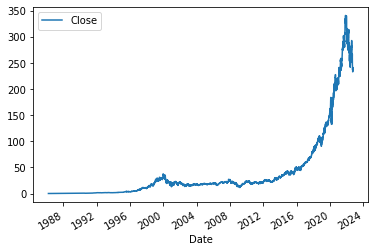

In [3]:
# Visualize microsoft stock prices
msft_hist.plot.line(y="Close", use_index=True)

In [4]:
# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [5]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [6]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [7]:
data.head(5)

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
1986-03-14,0.063158,1.0,0.060980,1.031789e+09,0.055536,0.063703,0.055536
1986-03-17,0.064247,1.0,0.063158,3.081600e+08,0.060980,0.064247,0.060980
1986-03-18,0.062613,0.0,0.064247,1.331712e+08,0.063158,0.064792,0.063158
1986-03-19,0.061524,0.0,0.062613,6.776640e+07,0.064247,0.064792,0.062069
1986-03-20,0.059891,0.0,0.061524,4.789440e+07,0.062613,0.063158,0.060980


In [8]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [9]:
from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.46987951807228917

<AxesSubplot:xlabel='Date'>

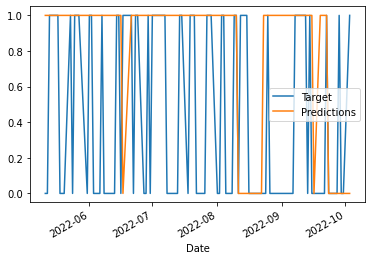

In [10]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

In [11]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

In [12]:
predictions = backtest(data, model, predictors)

In [13]:
predictions["Predictions"].value_counts()

0.0    7479
1.0     735
Name: Predictions, dtype: int64

In [14]:
precision_score(predictions["Target"], predictions["Predictions"])

0.49795918367346936

In [15]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()
weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [16]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [17]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]
predictions = backtest(data.iloc[365:], model, full_predictors)

In [18]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5720164609053497

In [19]:
# Show how many trades we would make

predictions["Predictions"].value_counts()

0.0    7606
1.0     243
Name: Predictions, dtype: int64

<AxesSubplot:xlabel='Date'>

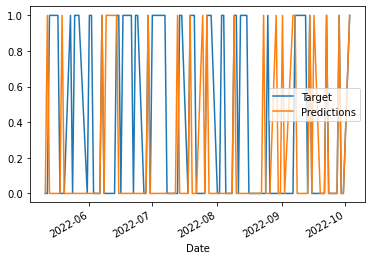

In [20]:
predictions.iloc[-100:].plot()